In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os
import time

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [3]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

os.environ["MODEL_DIR"] = os.path.join(models_base_path, "mnist_continuous_efficiency")

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Generating multiple digit classes

In [5]:
# Define the branches
classes = list(range(10))
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]

input_shape = (1, 28, 28)

In [6]:
# Define the SDE and import the model
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1
model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat,
    os.path.join(models_base_path, "mnist_continuous_alldigits/1/epoch_30_ckpt.pth")
).to(DEVICE)

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 6
Sampling class: 7
Sampling class: 8
Sampling class: 9
Total time taken: 80s


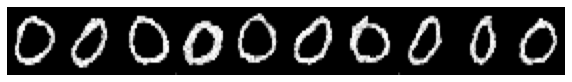

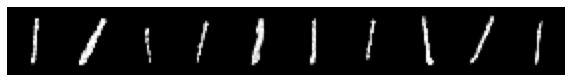

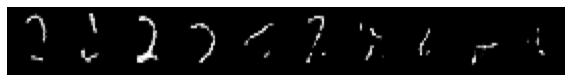

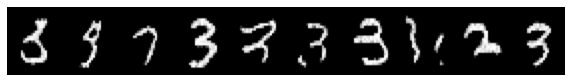

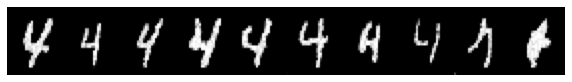

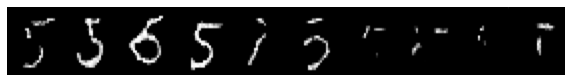

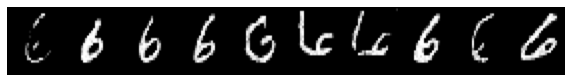

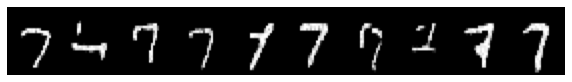

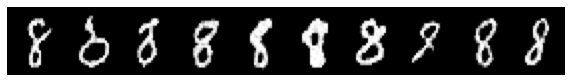

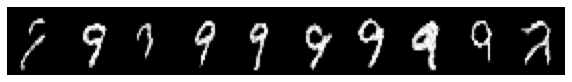

In [7]:
# Sample each class individually without taking advantage of branches
digit_samples = {}
time_a = time.time()
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    digit_samples[class_to_sample] = generate.generate_continuous_samples(
        model, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
        sampler="pc", t_limit=t_limit, num_steps=1000
    )
time_b = time.time()
linear_time = time_b - time_a
print("Total time taken: %ds" % linear_time)
for class_to_sample in classes:
    plot_mnist_digits(digit_samples[class_to_sample].cpu().numpy(), grid_size=(10, 1), title=None)

Sampling branch 1/19
Sampling branch 2/19
Sampling branch 3/19
Sampling branch 4/19
Sampling branch 5/19
Sampling branch 6/19
Sampling branch 7/19
Sampling branch 8/19
Sampling branch 9/19
Sampling branch 10/19
Sampling branch 11/19
Sampling branch 12/19
Sampling branch 13/19
Sampling branch 14/19
Sampling branch 15/19
Sampling branch 16/19
Sampling branch 17/19
Sampling branch 18/19
Sampling branch 19/19
Total time taken: 37s


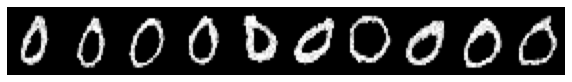

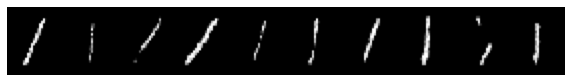

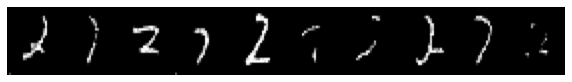

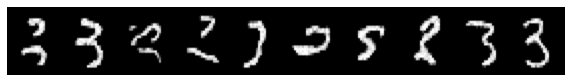

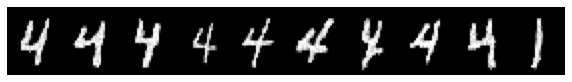

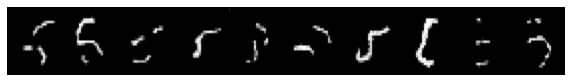

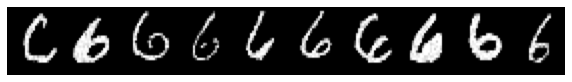

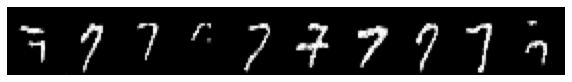

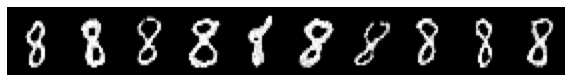

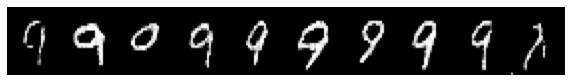

In [8]:
# Sample each digit by taking advantage of branches

# Sort the branches by starting time point (in reverse order), and generate along those
# branches, caching results; this guarantees that we will always find a cached batch
# (other than the first one)
cache = {}
sorted_branch_defs = sorted(branch_defs, key=(lambda t: -t[1]))

time_a = time.time()
# First branch
print("Sampling branch 1/%d" % len(sorted_branch_defs))
branch_def = sorted_branch_defs[0]
samples = generate.generate_continuous_samples(
    # Specify arbitrary class
    model, sde, branch_def[0][0],
    lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
    sampler="pc", t_limit=branch_def[2], t_start=branch_def[1],
    num_steps=int(1000 * (branch_def[2] - branch_def[1]))
)
for class_i in branch_def[0]:
    cache[class_i] = (branch_def[1], samples)

for i, branch_def in enumerate(sorted_branch_defs[1:]):
    print("Sampling branch %d/%d" % (i + 2, len(sorted_branch_defs)))
    cached_time, cached_samples = cache[branch_def[0][0]]
    assert cached_time == branch_def[2]
    samples = generate.generate_continuous_samples(
        model, sde, branch_def[0][0],
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
        sampler="pc", t_limit=branch_def[2], t_start=branch_def[1],
        num_steps=int(1000 * (branch_def[2] - branch_def[1])),
        initial_samples=cached_samples
    )
    for class_i in branch_def[0]:
        cache[class_i] = (branch_def[1], samples)
    
time_b = time.time()
branched_time = time_b - time_a
print("Total time taken: %ds" % branched_time)
for class_to_sample in cache:
    plot_mnist_digits(cache[class_to_sample][1].cpu().numpy(), grid_size=(10, 1), title=None)

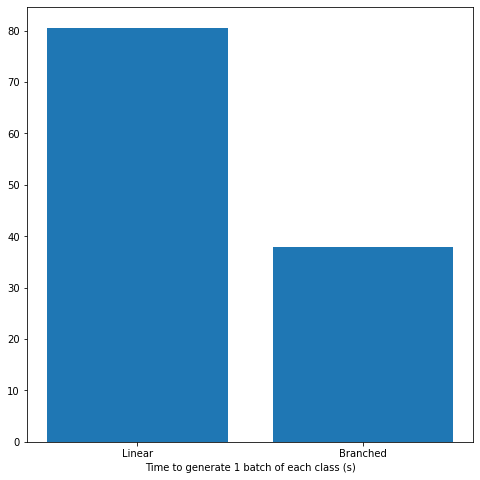

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
labels = ["Linear", "Branched"]
times = [linear_time, branched_time]
ax.bar(labels, times)
ax.set_xlabel("Time to generate 1 batch of each class (s)")
plt.show()

### Introducing a new digit class

In [21]:
# Define the branches
classes_1 = [0, 4, 9]
branch_defs_1 = [
    ((0, 4, 9), 0.5, 1),
    ((0,), 0, 0.5),
    ((4, 9), 0.35, 0.5),
    ((4,), 0, 0.35),
    ((9,), 0, 0.35)
]

classes_2 = [0, 4, 9, 7]
branch_defs_2 = [
    ((0, 4, 7, 9), 0.5, 1),
    ((0,), 0, 0.5),
    ((4, 7, 9), 0.38, 0.5),
    ((7,), 0, 0.38),
    ((4, 9), 0.35, 0.38),
    ((4,), 0, 0.35),
    ((9,), 0, 0.35)
]

classes_3 = [7]
branch_defs_3 = [
    ((7,), 0, 0.38)
]

branch_defs_4 = [
    ((0, 4, 9), 0, 1)
]

branch_defs_5 = [
    ((0, 4, 7, 9), 0, 1)
]

# Define the SDE and data loaders
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1

dataset_1 = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)
dataset_2 = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)
dataset_3 = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds_1 = np.isin(dataset_1.targets, classes_1)
dataset_1.data = dataset_1.data[inds_1]
dataset_1.targets = dataset_1.targets[inds_1]
inds_2 = np.isin(dataset_2.targets, classes_2)
dataset_2.data = dataset_2.data[inds_2]
dataset_2.targets = dataset_2.targets[inds_2]
inds_3 = np.isin(dataset_3.targets, classes_3)
dataset_3.data = dataset_3.data[inds_3]
dataset_3.targets = dataset_3.targets[inds_3]

data_loader_1 = torch.utils.data.DataLoader(dataset_1, batch_size=128, shuffle=True, num_workers=2)
data_loader_2 = torch.utils.data.DataLoader(dataset_2, batch_size=128, shuffle=True, num_workers=2)
data_loader_3 = torch.utils.data.DataLoader(dataset_3, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader_1))[0].shape[1:]

#### Train extra branch on branched model

In [11]:
def map_branch_def(branch_def, target_branch_defs):
    """
    Given a particular branch definition (i.e. a triplet), and a
    list of branch definitions, attempts to match that branch
    definition to the corresponding entry in the list. This
    mapping is based on whether or not the branch would need to be
    retrained. The query `branch_def` is matched to a target within
    `branch_defs` if the target's class indices are all present in
    the query, and the query time is a sub-interval of the target
    time.
    Arguments:
        `branch_def`: a branch definition (i.e. triplet of class index
            tuple, start time, and end time)
        `target_branch_defs`: a list of branch definitions
    Returns the index of the matched branch definition in `branch_defs`,
    or -1 if there is no suitable match found.
    """
    for i, target_branch_def in enumerate(target_branch_defs):
        if set(branch_def[0]).issuperset(set(target_branch_def[0])) \
            and branch_def[1] >= target_branch_def[1] \
            and branch_def[2] <= target_branch_def[2]:
            return i
    return -1

In [12]:
branched_model_1 = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat,
    os.path.join(models_base_path, "mnist_continuous_049/2/epoch_30_ckpt.pth")
).to(DEVICE)

In [13]:
# Create new model and copy over parameters
branched_model_2 = image_unet.MultitaskMNISTUNetTimeConcat(
    len(branch_defs_2), t_limit=t_limit
).to(DEVICE)

# Figure out which branches should be copied over to which ones
branch_map_inds = [
    map_branch_def(bd, branch_defs_1) for bd in branch_defs_2
]

# For each submodule, copy over the weights
# Careful: this assumes a particular kind of architecture!
for module_name, module_list in branched_model_1.named_children():
    if len(module_list) == 1:
        branched_model_2.get_submodule(module_name).load_state_dict(
            module_list.state_dict()
        )
    elif len(module_list) == len(branch_defs_1):
        target_module_list = branched_model_2.get_submodule(module_name)
        for target_i, source_i in enumerate(branch_map_inds):
            if source_i != -1:
                target_module_list[target_i].load_state_dict(
                    module_list[source_i].state_dict()
                )
    else:
        raise ValueError("Found module list of length %d" % len(module_list))

Sampling class: 0


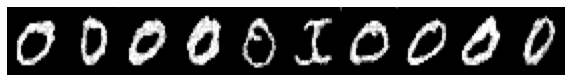

Sampling class: 4


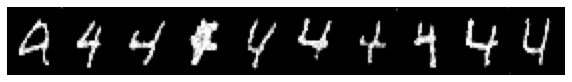

Sampling class: 9


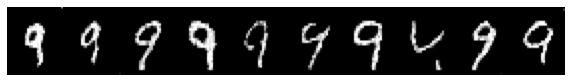

Sampling class: 7


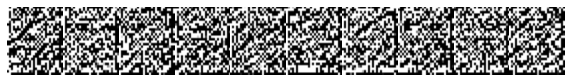

In [14]:
# Generate the digits to double check the match-up was done correctly
for class_to_sample in classes_2:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_samples(
        branched_model_2, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_2),
        sampler="pc", t_limit=t_limit
    )
    plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 1), title=None)

In [15]:
# Train the model, for the specific branches only

# Freeze all shared layers of the model, and freeze all task-specific
# layers other than the ones we want to train
for module_name, module_list in branched_model_2.named_children():
    if len(module_list) == 1:
        for p in module_list[0].parameters():
            p.requires_grad = False
    elif len(module_list) == len(branch_defs_2):
        for i in range(len(module_list)):
            if branch_map_inds[i] != -1:
                for p in module_list[i].parameters():
                    p.requires_grad = False
            else:
                for p in module_list[i].parameters():
                    p.requires_grad = True
    else:
        raise ValueError("Found module list of length %d" % len(module_list))

# Train
train_continuous_model.train_ex.run(
    "train_model",
    config_updates={
        "model": branched_model_2,
        "sde": sde,
        "data_loader": data_loader_3,
        "class_time_to_branch_index": lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_2),
        "num_epochs": 50,
        "learning_rate": 0.0001,  # Lower learning rate
        "t_limit": branch_defs_3[0][2],
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_model'
INFO - train - Started run with ID "1"
Loss: 643.73: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 13.81it/s]


Epoch 1 average Loss: 954.73


Loss: 410.40: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.35it/s]


Epoch 2 average Loss: 513.70


Loss: 334.77: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.37it/s]


Epoch 3 average Loss: 375.57


Loss: 288.69: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.29it/s]


Epoch 4 average Loss: 306.66


Loss: 245.44: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.30it/s]


Epoch 5 average Loss: 264.20


Loss: 230.07: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.29it/s]


Epoch 6 average Loss: 230.64


Loss: 181.57: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.34it/s]


Epoch 7 average Loss: 204.89


Loss: 195.55: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.06it/s]


Epoch 8 average Loss: 192.14


Loss: 168.14: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.32it/s]


Epoch 9 average Loss: 180.31


Loss: 163.41: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.34it/s]


Epoch 10 average Loss: 173.32


Loss: 163.50: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.33it/s]


Epoch 11 average Loss: 163.58


Loss: 141.52: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.27it/s]


Epoch 12 average Loss: 159.08


Loss: 151.87: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.30it/s]


Epoch 13 average Loss: 154.80


Loss: 153.82: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.32it/s]


Epoch 14 average Loss: 151.35


Loss: nan: 100%|████████████████████████████████████████████| 49/49 [00:03<00:00, 14.37it/s]


Epoch 15 average Loss: 145.40


Loss: 137.58: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.25it/s]


Epoch 16 average Loss: 143.34


Loss: 141.52: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.32it/s]


Epoch 17 average Loss: 141.13


Loss: 141.38: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.44it/s]


Epoch 18 average Loss: 136.67


Loss: 150.33: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.37it/s]


Epoch 19 average Loss: 137.07


Loss: 131.15: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.43it/s]


Epoch 20 average Loss: 129.75


Loss: 125.00: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.34it/s]


Epoch 21 average Loss: 129.39


Loss: 139.58: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.43it/s]


Epoch 22 average Loss: 127.63


Loss: 121.83: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.29it/s]


Epoch 23 average Loss: 123.99


Loss: 115.20: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.36it/s]


Epoch 24 average Loss: 121.43


Loss: 126.77: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.34it/s]


Epoch 25 average Loss: 122.05


Loss: 115.40: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.27it/s]


Epoch 26 average Loss: 119.60


Loss: 116.73: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.08it/s]


Epoch 27 average Loss: 119.27


Loss: 117.21: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.39it/s]


Epoch 28 average Loss: 117.64


Loss: 115.97: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.31it/s]


Epoch 29 average Loss: 112.19


Loss: 114.05: 100%|█████████████████████████████████████████| 49/49 [00:03<00:00, 14.34it/s]
INFO - train - Completed after 0:01:45


Epoch 30 average Loss: 115.88


Sampling class: 0


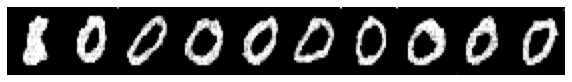

Sampling class: 4


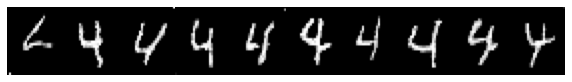

Sampling class: 9


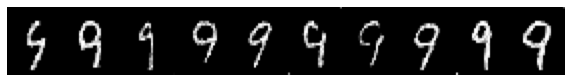

Sampling class: 7


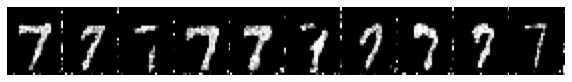

In [20]:
# Generate the digits
for class_to_sample in classes_2:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_samples(
        branched_model_2, sde, class_to_sample,
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_2),
        sampler="pc", t_limit=t_limit
    )
    plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 1), title=None)

#### Train additional digit on linear model

In [29]:
# Import the linear model
linear_model_1 = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat,
    os.path.join(models_base_path, "mnist_continuous_049_nobranch/1/epoch_30_ckpt.pth")
).to(DEVICE)

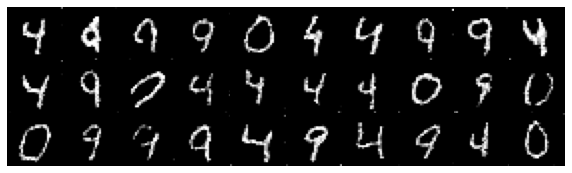

In [30]:
# Generate the digits
samples = generate.generate_continuous_samples(
    linear_model_1, sde, 0,  # Class to sample doesn't matter for linear model
    lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_4),
    sampler="pc", t_limit=t_limit
)
plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 3), title=None)

In [31]:
# Introduce new digit to linear model and train
train_continuous_model.train_ex.run(
    "train_model",
    config_updates={
        "model": linear_model_1,
        "sde": sde,
        "data_loader": data_loader_3,
        "class_time_to_branch_index": lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_5),
        "num_epochs": 5,
        "learning_rate": 0.001,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_model'
INFO - train - Started run with ID "4"
Loss: 46.15: 100%|██████████████████████████████████████████| 49/49 [00:02<00:00, 23.47it/s]


Epoch 1 average Loss: 54.48


Loss: 28.20: 100%|██████████████████████████████████████████| 49/49 [00:02<00:00, 23.69it/s]


Epoch 2 average Loss: 35.14


Loss: 38.29: 100%|██████████████████████████████████████████| 49/49 [00:02<00:00, 23.15it/s]


Epoch 3 average Loss: 36.24


Loss: 29.36: 100%|██████████████████████████████████████████| 49/49 [00:02<00:00, 23.66it/s]


Epoch 4 average Loss: 34.90


Loss: 44.37: 100%|██████████████████████████████████████████| 49/49 [00:02<00:00, 23.69it/s]
INFO - train - Completed after 0:00:11


Epoch 5 average Loss: 35.90


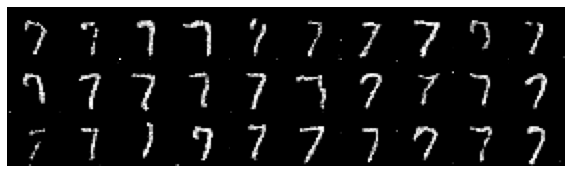

In [32]:
# Generate the digits
samples = generate.generate_continuous_samples(
    linear_model_1, sde, 0,  # Class to sample doesn't matter for linear model
    lambda c, t: class_time_to_branch_tensor(c, t, branch_defs_4),
    sampler="pc", t_limit=t_limit
)
plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 3), title=None)

#### Fine-tune the linear model on all digits